In [2]:
pip install fitz

In [3]:
pip install PyMuPDF

   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
    --------------------------------------- 0.3/16.6 MB ? eta -:--:--
    --------------------------------------- 0.3/16.6 MB ? eta -:--:--
    --------------------------------------- 0.3/16.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.6 MB 372.9 kB/s eta 0:00:44
   - -------------------------------------- 0.5/16.6 MB 372.9 kB/s eta 0:00:44
   - -------------------------------------- 0.5/16.6 MB 372.9 kB/s eta 0:00:44
   - -------------------------------------- 0.8/16.6 MB 364.8 kB/s eta 0:00:44
   - -------------------------------------- 0.8/16.6 MB 364.8 kB/s eta 0:00:44
   - -------------------------------------- 0.8/16.6 MB 364.8 kB/s eta 0:00:44
   - -------------------------------

In [277]:
import os
import pandas as pd
import re
import fitz
from tqdm import tqdm

In [279]:
def extract_metadata(text):
    """Извлекает метаданные из текста PDF"""
    metadata = {
        "title": "",
        "author": "",
        "publish_time": "",
        "tags": [],
        "hubs": []
    }
    
    # Извлечение заголовка (ищем строку, начинающуюся с #)
    title_match = re.search(r'#\s*(.+?)\n', text)
    if title_match:
        metadata["title"] = title_match.group(1).strip()
    else:
        # Альтернативный способ извлечения заголовка (первая непустая строка)
        lines = [line.strip() for line in text.split('\n') if line.strip()]
        if lines:
            metadata["title"] = lines[0]
    
    # Пробуем найти полную дату, например 22 мар 2024 в 14:14
    full_date_pattern = r"(\d{1,2}\s+[а-я]+\s+\d{4}\s+в\s+\d{1,2}:\d{2})"
    full_date_match = re.search(full_date_pattern, text)
    if full_date_match:
        metadata["publish_time"] = full_date_match.group(1)
    
    #  другое время
    relative_time_pattern = r"(\d+\s+(?:час|мин|день|дня|дней|неделю|недели|недель|месяц|месяца|месяцев)\s+назад)"
    relative_time_match = re.search(relative_time_pattern, text)
    if relative_time_match and not metadata["publish_time"]:
        metadata["publish_time"] = relative_time_match.group(1)
    
    # Извлечение автора (перед временем публикации)
    if full_date_match or relative_time_match:
        # Ищем текст перед временем публикации
        if full_date_match:
            time_str = full_date_match.group(1)
        else:
            time_str = relative_time_match.group(1)
        
        # Ищем имя автора перед временем
        author_pattern = r"([A-Za-zА-Яа-яЁё0-9_-]+)\s+" + re.escape(time_str)
        author_match = re.search(author_pattern, text)
        if author_match:
            metadata["author"] = author_match.group(1)
    
    # Извлечение тегов (строка, начинающееся с "Теги:" ")
    tags_pattern = r"(?:Теги):\s*([^\n]+)"
    tags_match = re.search(tags_pattern, text)
    if tags_match:
        metadata["tags"] = [tag.strip() for tag in tags_match.group(1).split(',')]
    
    # Извлечение хабов (ищем строку, начинающуюся с "Хабы:")
    hubs_pattern = r"Хабы:\s*([^\n]+)"
    hubs_match = re.search(hubs_pattern, text)
    if hubs_match:
        metadata["hubs"] = [hub.strip() for hub in hubs_match.group(1).split(',')]
    
    return metadata



In [281]:
def parse_pdf_content(text, filename):
    """Анализирует содержимое PDF и извлекает нужные данные"""
    # Извлекаем метаданные
    metadata = extract_metadata(text)
    
    # Основной контент (исключаем первые строки, которые могут быть метаданными)
    content_lines = text.split('\n')[10:]  # Пропускаем первые 10 строк
    content = "\n".join([line for line in content_lines if line.strip()])
    
    return {
        "file_name": filename,
        "title": metadata["title"],
        "author": metadata["author"],
        "publish_time": metadata["publish_time"],
        "tags": ", ".join(metadata["tags"]),
        "hubs": ", ".join(metadata["hubs"]),
        "content": content,
        "char_count": len(text),
        "word_count": len(text.split())
    }

In [283]:
def extract_text_from_pdf(file_path):
    """Извлекает текст из PDF файла и возвращает объединенный текст"""
    doc = fitz.open(file_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text
def process_pdf_files(folder_path):
    """Обрабатывает все PDF файлы в указанной папке"""
    # Находим все PDF файлы
    pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pdf')]
    
    if not pdf_files:
        print("PDF файлы не найдены в указанной папке")
        return None
    
    print(f"Найдено PDF файлов: {len(pdf_files)}")
    print("Список PDF файлов:")
    for i, pdf in enumerate(pdf_files, 1):
        print(f"{i}. {pdf}")
    
    # Парсим каждый PDF файл
    data = []
    for pdf_file in tqdm(pdf_files, desc="Обработка PDF файлов"):
        file_path = os.path.join(folder_path, pdf_file)
        text = extract_text_from_pdf(file_path)
        parsed_data = parse_pdf_content(text, pdf_file)
        data.append(parsed_data)
    
    return data


In [285]:
def save_to_csv(data, output_file):
    """Сохраняет данные в CSV файл"""
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"Данные сохранены в {output_file}")



In [287]:
# Обрабатываем PDF файлы
pdf_folder = "PDF2"  

parsed_data = process_pdf_files(pdf_folder)

if parsed_data:
    # Создаем DataFrame
    df = pd.DataFrame(parsed_data)
    print("\nПример данных:")
    print(df.head())
    
    # Сохраняем в CSV
    output_csv = "parsed_pdf_data.csv"
    save_to_csv(parsed_data, output_csv)

Найдено PDF файлов: 25
Список PDF файлов:
1. Cocoapods, Carthage, SPM как выбрать менеджер зависимостей в iOS.pdf
2. Deutsche Telekom и Perplexity объявили о новом «AI Phone» стоимостью менее 1 000 долларов _ Хабр.pdf
3. imgonline-com-ua-site2pdfB28eKGLy6EjA.pdf
4. OSINT & Hacking — как работает фишинг для нельзяграма _ Хабр3.pdf
5. uCloudlink представила смартфон для домашних животных _ Хабр.pdf
6. Yandex N.V. запретили в течение пяти лет создавать аналогичные «Яндексу» сервисы _ Хабр.pdf
7. Быстрое начало работы с Gitlab CICD.pdf
8. Все статьи подряд _ Хабр.pdf
9. Генеральный директор Mozilla покинула свой пост _ Хабр.pdf
10. За что безопасники будут гореть в аду_ _ Хабр.pdf
11. Заезжаем в Kotlin Multiplatform. Но какой ценой_ _ Хабр.pdf
12. ИИ-агенты в Альфа-Банке_ нейросети создают автотесты без участия человека _ Хабр.pdf
13. Инструменты наблюдаемости, о которых нужно знать в 2023 году.pdf
14. История российской науки_ напишем вместе_ _ Хабр.pdf
15. Как системному аналитику написа

Обработка PDF файлов: 100%|████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.86it/s]



Пример данных:
                                           file_name  \
0  Cocoapods, Carthage, SPM как выбрать менеджер ...   
1  Deutsche Telekom и Perplexity объявили о новом...   
2          imgonline-com-ua-site2pdfB28eKGLy6EjA.pdf   
3  OSINT & Hacking — как работает фишинг для нель...   
4  uCloudlink представила смартфон для домашних ж...   

                                               title         author  \
0  Название библиотеки. Именно его будут указыват...                  
1  Еще до начала MWC в Барселоне было очевидно, ч...  technokratiya   
2                 1 Корпоративный облачный провайдер                  
3                 1 Корпоративный облачный провайдер                  
4  Компания uCloudlink, которая создаёт решения д...        atomlib   

  publish_time                                               tags  \
0                                                   red_mad_robot   
1  1 час назад  смартфоны, ии, искусственный интеллект, мобиль...   
2            

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file_name     25 non-null     object
 1   title         25 non-null     object
 2   author        25 non-null     object
 3   publish_time  25 non-null     object
 4   tags          25 non-null     object
 5   hubs          25 non-null     object
 6   content       25 non-null     object
 7   char_count    25 non-null     int64 
 8   word_count    25 non-null     int64 
dtypes: int64(2), object(7)
memory usage: 1.9+ KB


In [291]:
df.head(26)

file_name  \
0   Cocoapods, Carthage, SPM как выбрать менеджер ...   
1   Deutsche Telekom и Perplexity объявили о новом...   
2           imgonline-com-ua-site2pdfB28eKGLy6EjA.pdf   
3   OSINT & Hacking — как работает фишинг для нель...   
4   uCloudlink представила смартфон для домашних ж...   
5   Yandex N.V. запретили в течение пяти лет созда...   
6             Быстрое начало работы с Gitlab CICD.pdf   
7                        Все статьи подряд _ Хабр.pdf   
8   Генеральный директор Mozilla покинула свой пос...   
9   За что безопасники будут гореть в аду_ _ Хабр.pdf   
10  Заезжаем в Kotlin Multiplatform. Но какой цено...   
11  ИИ-агенты в Альфа-Банке_ нейросети создают авт...   
12  Инструменты наблюдаемости, о которых нужно зна...   
13  История российской науки_ напишем вместе_ _ Ха...   
14  Как системному аналитику написать хорошее резю...   
15  Как создать аппаратный эмулятор CD-ROM без пая...   
16         Как создать аппаратный эмулятор CD-ROM.pdf   
17                                Компании _ Хабр.pdf   
18                                       Компании.pdf   
19  Может ли chatGPT забронировать столик в рестор...   
20                                   Новые утечки.pdf   
21                 Почему Data Science не для вас.pdf   
22  Программисты, директора и медики больше других...   
23  Путь ИТ-инженера_ оффлайн ивент для студентов ...   
24  Российские издательства вынуждены повысить цен...   

                                                title         author  \
0   Название библиотеки. Именно его будут указыват...                  
1   Еще до начала MWC в Барселоне было очевидно, ч...  technokratiya   
2                  1 Корпоративный облачный провайдер                  
3                  1 Корпоративный облачный провайдер                  
4   Компания uCloudlink, которая создаёт решения д...        atomlib   
5   Нидерландская компания Yandex N.V. по итогам р...                  
6     variabiles definitions for easier reuse of valu                  
7                                          Все потоки           d1g1   
8   Митчелл Бейкер, гендиректор Mozilla с 2020 год...                  
9   Для привлечения внимания расскажу историю. Уже...                  
10  Привет! Меня зовут Денис, я занимаюсь коммерче...                  
11                                             404.32                  
12                                             2376.9                  
13                                               4.58         данных   
14                              look, use the source!                  
15                                            2394.92                  
16                                            2394.92                  
17                                         Все потоки                  
18                                          RUVDS.com                  
19                                     Check webhooks                  
20                                               4.74                  
21  Data Science сейчас во многом благодаря активн...                  
22                                                  0          vvmax   
23                                             106.42        CrocInc   
24  Цены на печатные книги с начала 2025 года выра...  LizzieSimpson   

           publish_time                                               tags  \
0                                                            red_mad_robot   
1           1 час назад  смартфоны, ии, искусственный интеллект, мобиль...   
2                                                    взлом, соцсети, osint   
3                                                                    взлом   
4           1 час назад  искусственный интеллект, смартфоны, домашние ж...   
5                                  яндекс, yandex n.v., разделение бизнеса   
6                                                                    ci/cd   
7           1 час назад                                         

# NLP

In [ ]:
df_json = pd.read_csv("parsJson.csv")
df_pdf = pd.read_csv("parsed_pdf_data.csv")

# Переименование столбцов (если нужно)
df_pdf = df_pdf.rename(columns={"file_name": "source_file", "content": "text"})

# Объединение
combined_df = pd.concat([df_json, df_pdf], ignore_index=True)

# Очистка данных
combined_df.dropna(subset=["text"], inplace=True)
combined_df["views"].fillna(0, inplace=True)

# Сохранение
combined_df.to_csv("combined_dataset.csv", index=False)
print("Общий датасет сохранен как 'combined_dataset.csv'")

In [ ]:
import nltk
>>> nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [353]:
import pandas as pd
import string
import re
import nltk
import pymorphy3

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


In [355]:
df =pd.read_csv("combined_dataset.csv")

In [356]:
df.head()

text             date  rate  \
0  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
1  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
2  Из совместного исследования издателя компьютер...    29 июля 13:50  12.0   
3  По статистике The Esports Observer за I полови...     9 июля 09:33  18.0   
4  Компании SuperData Research и PayPal провели с...  11 апреля 12:43  11.0   

     views             source_file title author publish_time tags hubs  \
0   2300.0  Cybersport.Metaratings   NaN    NaN          NaN  NaN  NaN   
1   2300.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
2   2800.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
3   6200.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
4  10000.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   

   char_count  word_count  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          1137 non-null   object 
 1   date          1112 non-null   object 
 2   rate          1112 non-null   float64
 3   views         1137 non-null   float64
 4   source_file   1137 non-null   object 
 5   title         25 non-null     object 
 6   author        7 non-null      object 
 7   publish_time  7 non-null      object 
 8   tags          21 non-null     object 
 9   hubs          21 non-null     object 
 10  char_count    25 non-null     float64
 11  word_count    25 non-null     float64
dtypes: float64(4), object(8)
memory usage: 106.7+ KB


## Предварительная обработка данных

In [362]:
def remove_punctuation(text): 
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

st = '❯\xa0—«»'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [364]:
df['prep_text'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(text.lower())))) for text in df['text']]

In [365]:
df.head()

text             date  rate  \
0  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
1  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
2  Из совместного исследования издателя компьютер...    29 июля 13:50  12.0   
3  По статистике The Esports Observer за I полови...     9 июля 09:33  18.0   
4  Компании SuperData Research и PayPal провели с...  11 апреля 12:43  11.0   

     views             source_file title author publish_time tags hubs  \
0   2300.0  Cybersport.Metaratings   NaN    NaN          NaN  NaN  NaN   
1   2300.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
2   2800.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
3   6200.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
4  10000.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   

   char_count  word_count                                          prep_text  
0         NaN         NaN   декабря состоялась церемония награждения лаур...  
1         NaN         NaN   декабря состоялась церемония награждения лаур...  
2         NaN         NaN  из совместного исследования издателя компьютер...  
3         NaN         NaN  по статистике the esports observer за i полови...  
4         NaN         NaN  компании superdata research и paypal провели с...

In [366]:
df['text'][0]

'7 декабря состоялась церемония награждения лауреатов премии Рунета 2021 года. В этом году на премию было подано 1097 работ за вклад в развитие российского сегмента сети интернет в девять основных и четыре специальные номинации. Финалистами конкурса в каждой номинации стали по 10 организаций. \n\r\nЛауреатами премии Рунета 2021 стали 52 компании и 3 персоны. Причем раньше организаторы (Российская ассоциация электронных коммуникаций — РАЭК) награждали несколько лучших представителей в каждой из номинации, по мнению экспертного сообщества. В этом году они обратились к помощи искусственного интеллекта и добавили еще одного лауреата, который выбирался именно по мнению ИИ. \n\r\nНоминация «Государство и Общество», победители:\n\n\n Благотворительный фонд «Подари жизнь»;\n АНО «Диалог»;\n Правительство Москвы, проект Цифровая экосистема Москвы;\n ФНС России;\n Программа «Пушкинская карта» / АО «Почта Банк».\n\r\nНоминация «СМИ и Массовые коммуникации»: \n\n\n Телеканал 360;\n Медиахолдинг In

In [367]:
df['prep_text'][0]

' декабря состоялась церемония награждения лауреатов премии рунета года в этом году на премию было подано работ за вклад в развитие российского сегмента сети интернет в девять основных и четыре специальные номинации финалистами конкурса в каждой номинации стали по организаций лауреатами премии рунета стали компании и персоны причем раньше организаторы российская ассоциация электронных коммуникаций раэк награждали несколько лучших представителей в каждой из номинации по мнению экспертного сообщества в этом году они обратились к помощи искусственного интеллекта и добавили еще одного лауреата который выбирался именно по мнению ии номинация государство и общество победители благотворительный фонд подари жизнь ано диалог правительство москвы проект цифровая экосистема москвы фнс россии программа пушкинская карта ао почта банк номинация сми и массовые коммуникации телеканал медиахолдинг independent media ао коммерсантъ номинация “образование и кадры” правительство москвы проект “московская э

In [368]:
russian_stopwords = stopwords.words("russian") 

In [369]:
russian_stopwords 

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [370]:
def tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    text = " ".join(tokens)
    return text

In [371]:
df['tokenize_text'] = [tokenize(text) for text in df['prep_text']]

In [372]:
df.head()

text             date  rate  \
0  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
1  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
2  Из совместного исследования издателя компьютер...    29 июля 13:50  12.0   
3  По статистике The Esports Observer за I полови...     9 июля 09:33  18.0   
4  Компании SuperData Research и PayPal провели с...  11 апреля 12:43  11.0   

     views             source_file title author publish_time tags hubs  \
0   2300.0  Cybersport.Metaratings   NaN    NaN          NaN  NaN  NaN   
1   2300.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
2   2800.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
3   6200.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
4  10000.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   

   char_count  word_count                                          prep_text  \
0         NaN         NaN   декабря состоялась церемония награждения лаур...   
1         NaN         NaN   декабря состоялась церемония награждения лаур...   
2         NaN         NaN  из совместного исследования издателя компьютер...   
3         NaN         NaN  по статистике the esports observer за i полови...   
4         NaN         NaN  компании superdata research и paypal провели с...   

                                       tokenize_text  
0  декабря состоялась церемония награждения лауре...  
1  декабря состоялась церемония награждения лауре...  
2  совместного исследования издателя компьютерных...  
3  статистике the esports observer i половину год...  
4  компании superdata research paypal провели сов...

In [373]:
df['tokenize_text'][0]

'декабря состоялась церемония награждения лауреатов премии рунета года году премию подано работ вклад развитие российского сегмента сети интернет девять основных четыре специальные номинации финалистами конкурса каждой номинации стали организаций лауреатами премии рунета стали компании персоны причем раньше организаторы российская ассоциация электронных коммуникаций раэк награждали несколько лучших представителей каждой номинации мнению экспертного сообщества году обратились помощи искусственного интеллекта добавили одного лауреата который выбирался именно мнению ии номинация государство общество победители благотворительный фонд подари жизнь ано диалог правительство москвы проект цифровая экосистема москвы фнс россии программа пушкинская карта ао почта банк номинация сми массовые коммуникации телеканал медиахолдинг independent media ао коммерсантъ номинация “ образование кадры ” правительство москвы проект “ московская электронная школа ” мэш проект программы “ сбер детей родителей ” 

In [374]:
stemmer = SnowballStemmer("russian")

stem_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
    except Exception as e:
        print(e)
        
df['text_stem'] = stem_list

In [375]:
df.head()

text             date  rate  \
0  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
1  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
2  Из совместного исследования издателя компьютер...    29 июля 13:50  12.0   
3  По статистике The Esports Observer за I полови...     9 июля 09:33  18.0   
4  Компании SuperData Research и PayPal провели с...  11 апреля 12:43  11.0   

     views             source_file title author publish_time tags hubs  \
0   2300.0  Cybersport.Metaratings   NaN    NaN          NaN  NaN  NaN   
1   2300.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
2   2800.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
3   6200.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
4  10000.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   

   char_count  word_count                                          prep_text  \
0         NaN         NaN   декабря состоялась церемония награждения лаур...   
1         NaN         NaN   декабря состоялась церемония награждения лаур...   
2         NaN         NaN  из совместного исследования издателя компьютер...   
3         NaN         NaN  по статистике the esports observer за i полови...   
4         NaN         NaN  компании superdata research и paypal провели с...   

                                       tokenize_text  \
0  декабря состоялась церемония награждения лауре...   
1  декабря состоялась церемония награждения лауре...   
2  совместного исследования издателя компьютерных...   
3  статистике the esports observer i половину год...   
4  компании superdata research paypal провели сов...   

                                           text_stem  
0  декабр состоя церемон награжден лауреат прем р...  
1  декабр состоя церемон награжден лауреат прем р...  
2  совместн исследован издател компьютерн игр war...  
3  статистик the esports observer i половин год в...  
4  компан superdata research paypal провел совмес...

In [376]:
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [384]:
%%time
lemm_texts_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
    
df['text_lemm'] = lemm_texts_list

CPU times: total: 3min 45s
Wall time: 3min 51s


In [391]:
df.head()

text             date  rate  \
0  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
1  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
2  Из совместного исследования издателя компьютер...    29 июля 13:50  12.0   
3  По статистике The Esports Observer за I полови...     9 июля 09:33  18.0   
4  Компании SuperData Research и PayPal провели с...  11 апреля 12:43  11.0   

     views             source_file title author publish_time tags hubs  \
0   2300.0  Cybersport.Metaratings   NaN    NaN          NaN  NaN  NaN   
1   2300.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
2   2800.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
3   6200.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
4  10000.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   

   char_count  word_count                                          prep_text  \
0         NaN         NaN   декабря состоялась церемония награждения лаур...   
1         NaN         NaN   декабря состоялась церемония награждения лаур...   
2         NaN         NaN  из совместного исследования издателя компьютер...   
3         NaN         NaN  по статистике the esports observer за i полови...   
4         NaN         NaN  компании superdata research и paypal провели с...   

                                       tokenize_text  \
0  декабря состоялась церемония награждения лауре...   
1  декабря состоялась церемония награждения лауре...   
2  совместного исследования издателя компьютерных...   
3  статистике the esports observer i половину год...   
4  компании superdata research paypal провели сов...   

                                           text_stem  \
0  декабр состоя церемон награжден лауреат прем р...   
1  декабр состоя церемон награжден лауреат прем р...   
2  совместн исследован издател компьютерн игр war...   
3  статистик the esports observer i половин год в...   
4  компан superdata research paypal провел совмес...   

                                           text_lemm  
0  декабрь состояться церемония награждение лауре...  
1  декабрь состояться церемония награждение лауре...  
2  совместный исследование издатель компьютерный ...  
3  статистика the esports observer i половина год...  
4  компания superdata research paypal провести со...

In [392]:
df['text_lemm'][0]

'декабрь состояться церемония награждение лауреат премия рунет год год премия подать работа вклад развитие российский сегмент сеть интернет девять основный четыре специальный номинация финалист конкурс каждый номинация стать организация лауреат премия рунет стать компания персона причём ранний организатор российский ассоциация электронный коммуникация раэк награждать несколько хороший представитель каждый номинация мнение экспертный сообщество год обратиться помощь искусственный интеллект добавить один лауреат который выбираться именно мнение ия номинация государство общество победитель благотворительный фонд подарить жизнь ано диалог правительство москва проект цифровой экосистема москва фнс россия программа пушкинский карта ао почта банк номинация сми массовый коммуникация телеканал медиахолдинг independent media ао коммерсантъ номинация “ образование кадр ” правительство москва проект “ московский электронный школа ” мэш проект программа “ сбер ребёнок родитель ” совместно rambler c

In [393]:
df['text_lemm'] = [tokenize(text) for text in df['text_lemm']]

In [394]:
df.head()

text             date  rate  \
0  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
1  7 декабря состоялась церемония награждения лау...  8 декабря 09:30   6.0   
2  Из совместного исследования издателя компьютер...    29 июля 13:50  12.0   
3  По статистике The Esports Observer за I полови...     9 июля 09:33  18.0   
4  Компании SuperData Research и PayPal провели с...  11 апреля 12:43  11.0   

     views             source_file title author publish_time tags hubs  \
0   2300.0  Cybersport.Metaratings   NaN    NaN          NaN  NaN  NaN   
1   2300.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
2   2800.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
3   6200.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   
4  10000.0         ESforce Holding   NaN    NaN          NaN  NaN  NaN   

   char_count  word_count                                          prep_text  \
0         NaN         NaN   декабря состоялась церемония награждения лаур...   
1         NaN         NaN   декабря состоялась церемония награждения лаур...   
2         NaN         NaN  из совместного исследования издателя компьютер...   
3         NaN         NaN  по статистике the esports observer за i полови...   
4         NaN         NaN  компании superdata research и paypal провели с...   

                                       tokenize_text  \
0  декабря состоялась церемония награждения лауре...   
1  декабря состоялась церемония награждения лауре...   
2  совместного исследования издателя компьютерных...   
3  статистике the esports observer i половину год...   
4  компании superdata research paypal провели сов...   

                                           text_stem  \
0  декабр состоя церемон награжден лауреат прем р...   
1  декабр состоя церемон награжден лауреат прем р...   
2  совместн исследован издател компьютерн игр war...   
3  статистик the esports observer i половин год в...   
4  компан superdata research paypal провел совмес...   

                                           text_lemm  
0  декабрь состояться церемония награждение лауре...  
1  декабрь состояться церемония награждение лауре...  
2  совместный исследование издатель компьютерный ...  
3  статистика the esports observer i половина год...  
4  компания superdata research paypal провести со...

## Облако слов

In [208]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


In [400]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [402]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

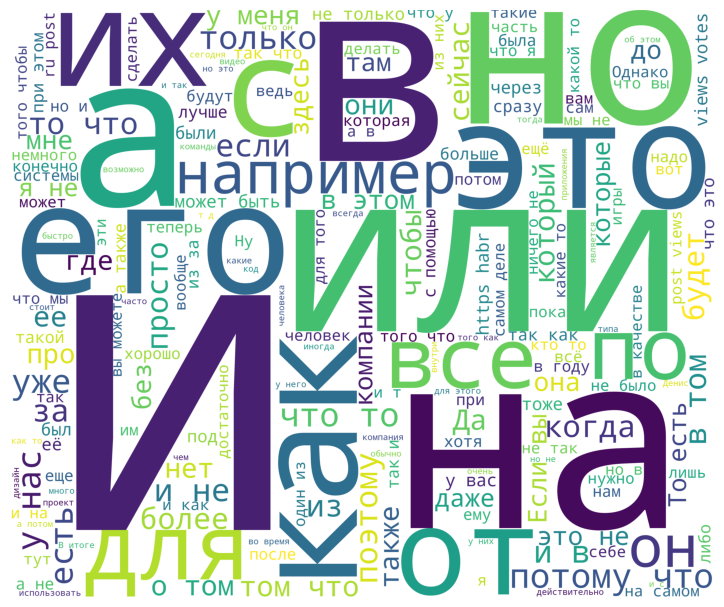

In [404]:
corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

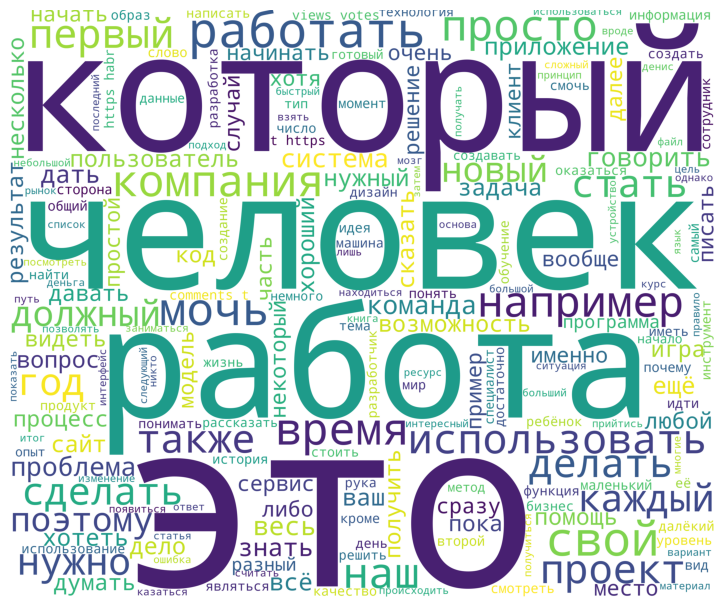

In [405]:
corpus = get_corpus(df['text_lemm'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

In [406]:
# Получение облака слов
def get_wordCloud2(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(corpus)
    return wordCloud

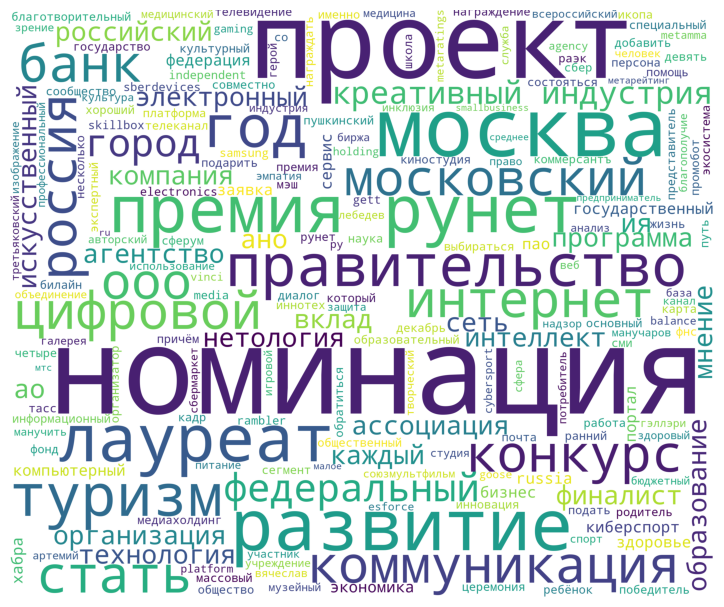

In [407]:
corpus = df['text_lemm'][0]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

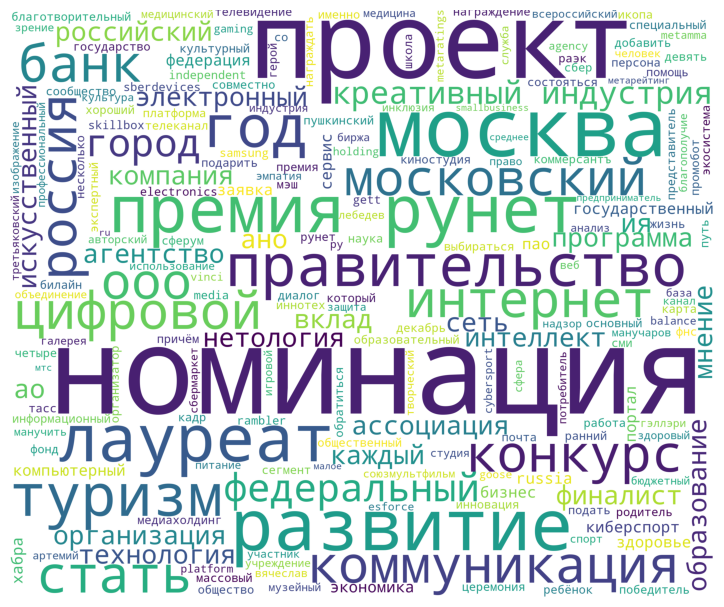

In [408]:
corpus = df['text_lemm'][1]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

In [409]:
df['text_lemm'][1]

'декабрь состояться церемония награждение лауреат премия рунет год год премия подать работа вклад развитие российский сегмент сеть интернет девять основный четыре специальный номинация финалист конкурс каждый номинация стать организация лауреат премия рунет стать компания персона причём ранний организатор российский ассоциация электронный коммуникация раэк награждать несколько хороший представитель каждый номинация мнение экспертный сообщество год обратиться помощь искусственный интеллект добавить лауреат который выбираться именно мнение ия номинация государство общество победитель благотворительный фонд подарить жизнь ано диалог правительство москва проект цифровой экосистема москва фнс россия программа пушкинский карта ао почта банк номинация сми массовый коммуникация телеканал медиахолдинг independent media ао коммерсантъ номинация “ образование кадр ” правительство москва проект “ московский электронный школа ” мэш проект программа “ сбер ребёнок родитель ” совместно rambler co ооо

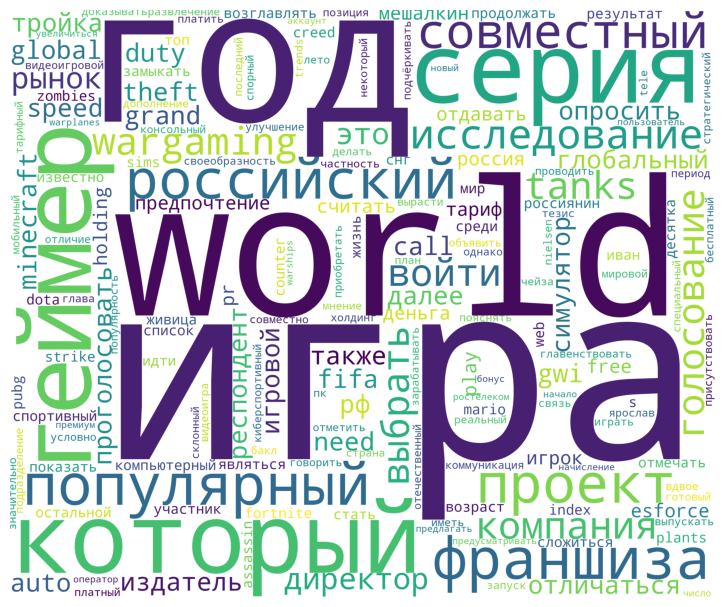

In [410]:
corpus = df['text_lemm'][2]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

In [411]:
df['text_lemm'][2]

'совместный исследование издатель компьютерный игра wargaming компания global web index gwi стать известно популярный игра среди россиянин возраст год являться world of tanks проголосовать опросить тройка замыкать франшиза need for speed игра minecraft результат глобальный голосование отличаться российский список франшиза продолжать спортивный симулятор fifa который выбрать респондент далее идти симулятор жизнь sims десятка популярный игровой серия также войти grand theft auto call of duty counter strike assassin ’ s creed dota остальной геймер рф проголосовать проект топ популярный игра мир отличаться возглавлять франшиза call of duty который выбрать опросить тройка также войти pubg fifa далее предпочтение участник глобальный голосование сложиться серия mario minecraft серия plants and zombies серия grand theft auto серия need for speed fortnite франшиза выбрать респондент pr директор wargaming снг иван живица отмечать исследование показать своеобразность рынок видеоигровой развлечени

## Векторизация текстовых данных

In [420]:
from sklearn.feature_extraction.text import CountVectorizer

In [422]:
df['text_lemm'][0]

'декабрь состояться церемония награждение лауреат премия рунет год год премия подать работа вклад развитие российский сегмент сеть интернет девять основный четыре специальный номинация финалист конкурс каждый номинация стать организация лауреат премия рунет стать компания персона причём ранний организатор российский ассоциация электронный коммуникация раэк награждать несколько хороший представитель каждый номинация мнение экспертный сообщество год обратиться помощь искусственный интеллект добавить лауреат который выбираться именно мнение ия номинация государство общество победитель благотворительный фонд подарить жизнь ано диалог правительство москва проект цифровой экосистема москва фнс россия программа пушкинский карта ао почта банк номинация сми массовый коммуникация телеканал медиахолдинг independent media ао коммерсантъ номинация “ образование кадр ” правительство москва проект “ московский электронный школа ” мэш проект программа “ сбер ребёнок родитель ” совместно rambler co ооо

In [424]:
vectorizer = CountVectorizer()
vectorizer.fit(df['text_lemm'])

CountVectorizer()

In [425]:
print(vectorizer.vocabulary_)

{'декабрь': 30595, 'состояться': 63914, 'церемония': 71049, 'награждение': 44083, 'лауреат': 40291, 'премия': 55365, 'рунет': 60668, 'год': 29333, 'подать': 52489, 'работа': 57984, 'вклад': 26416, 'развитие': 58269, 'российский': 60470, 'сегмент': 61800, 'сеть': 62135, 'интернет': 36043, 'девять': 30515, 'основный': 49049, 'четыре': 71560, 'специальный': 64161, 'номинация': 46961, 'финалист': 69507, 'конкурс': 38616, 'каждый': 36675, 'стать': 64690, 'организация': 48820, 'компания': 38433, 'персона': 51584, 'причём': 56272, 'ранний': 58841, 'организатор': 48811, 'ассоциация': 22785, 'электронный': 72930, 'коммуникация': 38384, 'раэк': 59376, 'награждать': 44081, 'несколько': 46350, 'хороший': 70667, 'представитель': 55246, 'мнение': 42978, 'экспертный': 72800, 'сообщество': 63738, 'обратиться': 47611, 'помощь': 53937, 'искусственный': 36317, 'интеллект': 35985, 'добавить': 31513, 'который': 39237, 'выбираться': 27651, 'именно': 35619, 'ия': 36597, 'государство': 29636, 'общество': 4778

In [426]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)
count_matrix = vectorizer.fit_transform(df['text_lemm'])

In [427]:
count_matrix.shape

(1137, 269990)

In [429]:
vectorizer.get_feature_names_out()[45000:46000]

array(['выгрузка файл', 'выдавать', 'выдавать вариант', 'выдавать вообще',
       'выдавать вообще проблема', 'выдавать дать', 'выдавать клиент',
       'выдавать команда', 'выдавать кредит', 'выдавать место',
       'выдавать некого', 'выдавать некого digital', 'выдавать нужный',
       'выдавать нужный информация', 'выдавать ошибка',
       'выдавать потрепать', 'выдавать потрепать жизнь', 'выдавать право',
       'выдавать предупреждение', 'выдавать просто', 'выдавать результат',
       'выдавать свой', 'выдаваться', 'выдавить', 'выдавливать', 'выдать',
       'выдать далёкий', 'выдать деньга', 'выдать документ',
       'выдать информация', 'выдать комбинезон',
       'выдать комбинезон пожалуйста', 'выдать направление',
       'выдать направление переустановка', 'выдать отдать',
       'выдать отдать сомнительный', 'выдать патент', 'выдать разрешение',
       'выдать ранний', 'выдать ранний слишком', 'выдать результат',
       'выдать свой', 'выдать следующий', 'выдать следующий не

In [431]:
vectorizer.get_feature_names_out()[3030]

'conf sd карта'

In [432]:
vectorizer.get_feature_names_out()[25756]

'биржа'

In [433]:
print(count_matrix)

  (0, 56858)	1
  (0, 225501)	1
  (0, 257197)	1
  (0, 120706)	1
  (0, 104568)	5
  (0, 176603)	6
  (0, 206462)	6
  (0, 50073)	4
  (0, 158487)	1
  (0, 191647)	1
  (0, 35890)	2
  (0, 194969)	6
  (0, 205205)	2
  (0, 211999)	1
  (0, 213700)	2
  (0, 84135)	3
  (0, 56412)	1
  (0, 144597)	1
  (0, 260569)	1
  (0, 226827)	1
  (0, 133647)	20
  (0, 251644)	2
  (0, 96737)	3
  (0, 88120)	2
  (0, 230482)	3
  :	:
  (1136, 191825)	1
  (1136, 94474)	1
  (1136, 14136)	1
  (1136, 158025)	1
  (1136, 159971)	1
  (1136, 202300)	1
  (1136, 3865)	1
  (1136, 114300)	1
  (1136, 3792)	1
  (1136, 114305)	1
  (1136, 3866)	1
  (1136, 10589)	1
  (1136, 114301)	1
  (1136, 96730)	1
  (1136, 3793)	1
  (1136, 132694)	1
  (1136, 45424)	1
  (1136, 5505)	1
  (1136, 114310)	1
  (1136, 243262)	1
  (1136, 45425)	1
  (1136, 5506)	1
  (1136, 114311)	1
  (1136, 62599)	1
  (1136, 243263)	1


## TF-IDE

In [440]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [442]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))

In [444]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_lemm'])

CPU times: total: 20.2 s
Wall time: 20.6 s


In [445]:
tfidf_matrix.shape

(1137, 10000)

In [446]:
tfidf_vectorizer.get_feature_names_out()[:100]

array(['about', 'academy', 'access', 'accessibility', 'action', 'actions',
       'active', 'add', 'address', 'adobe', 'advanced', 'after', 'agency',
       'agent', 'agile', 'agima', 'ai', 'aic', 'airbnb', 'al', 'alibaba',
       'all', 'alpha', 'am', 'amazon', 'an', 'analysis', 'analytics',
       'and', 'android', 'android ios', 'android приложение',
       'android разработка', 'android разработчик', 'angular', 'any',
       'apache', 'api', 'app', 'app store', 'append', 'apple',
       'application', 'apps', 'ar', 'architecture', 'arduino', 'are',
       'args', 'arm', 'array', 'art', 'as', 'async', 'at', 'audio',
       'auto', 'avito', 'awards', 'awesome', 'aws', 'azure', 'back',
       'backend', 'background', 'badoo', 'bar', 'base', 'based', 'bash',
       'basic', 'be', 'before', 'best', 'beta', 'beyond', 'big',
       'big data', 'bin', 'black', 'block', 'blog', 'blue', 'bluetooth',
       'body', 'bold', 'boolean', 'boot', 'bootstrap', 'bot', 'box',
       'brain', 'break',

In [447]:
tfidf_vectorizer.get_feature_names_out()[8530]

'статья рассказать'

In [448]:
tfidf_vectorizer.get_feature_names_out()[7202]

'пятно'

In [449]:
print(tfidf_matrix)

  (0, 2313)	0.02373449756024194
  (0, 8339)	0.024553085295820884
  (0, 9532)	0.03400591766052515
  (0, 4035)	0.1605327446277684
  (0, 6674)	0.15289484356691518
  (0, 7701)	0.17100121504056132
  (0, 2113)	0.03631432687991682
  (0, 6076)	0.022816407959369463
  (0, 7209)	0.008519293119814631
  (0, 1563)	0.050607761077672314
  (0, 7301)	0.08438510870113738
  (0, 7667)	0.033533065882287626
  (0, 7900)	0.02409455149195881
  (0, 7957)	0.030983601401116605
  (0, 3264)	0.041936322773787886
  (0, 2302)	0.027223311905179844
  (0, 5442)	0.013778016670141585
  (0, 9642)	0.017721097210545073
  (0, 8389)	0.017462698824964287
  (0, 5018)	0.6625400913919202
  (0, 9336)	0.06932243776764782
  (0, 3674)	0.07438306266801968
  (0, 3394)	0.018857237181785554
  (0, 8511)	0.029089582517272786
  (0, 5401)	0.033082175724452025
  :	:
  (1136, 937)	0.03981921021378476
  (1136, 1451)	0.03610683630038214
  (1136, 692)	0.03837912390555978
  (1136, 259)	0.03943383588596541
  (1136, 3747)	0.03610683630038214
  (1136, 2

In [351]:

df_json = pd.read_csv("parsJson.csv")
df_pdf = pd.read_csv("parsed_pdf_data.csv")

# Переименование столбцов (если нужно)
df_pdf = df_pdf.rename(columns={"file_name": "source_file", "content": "text"})

# Объединение
combined_df = pd.concat([df_json, df_pdf], ignore_index=True)

# Очистка данных
combined_df.dropna(subset=["text"], inplace=True)
combined_df["views"].fillna(0, inplace=True)

# Сохранение
combined_df.to_csv("combined_dataset.csv", index=False)
print("Общий датасет сохранен как 'combined_dataset.csv'")


C:\Users\user\AppData\Local\Temp\ipykernel_11212\4201267596.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df["views"].fillna(0, inplace=True)


Общий датасет сохранен как 'combined_dataset.csv'
